Calculate and plot meridional heat transport
Uses two methods because of diagnostics available:
From surface heat flux assuming steady state
From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [8]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as c
from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# Set 1-degree data to be different for MHT diagnostics:
exptdata.exptdict['1deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle'
exptdata.exptdict['1deg']['expt'] = '1deg_jra55v13_iaf_spinup1_B1_lastcycle'

tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
figdir = '/g/data1/v45/pas561/access-om2_amoc/'
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [ ]:
## This is the method we use to get around memory issues. To implement, use:
## dask-scheduler # get the tcp code from this call in a jupyter new terminal, then run command below in a another terminal
## dask-worker tcp://10.0.64.4:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157

## dask-worker tcp://10.0.64.19:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/e14/pas561


#cc.start_cluster()

client=Client('tcp://10.0.64.19:8786', local_dir='/local/e14/pas561')
client

In [ ]:
cc.get_ncfiles(exptdata.exptdict['1deg']['expt'])

In [ ]:
cc.get_variables(exptdata.exptdict['1deg']['expt'],'ocean_month.nc')

In [ ]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

In [ ]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')

In [9]:
# Infer from surface heat flux:
def find_AtlMHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    print(ekey)
    print(expt)
    n_files = exptdata.exptdict[ekey]['n_files']
    n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    
    NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
    
    if ekey == '1deg':
        Ocean_File = os.path.join(NYFCntrlDir,'om2_1_amoc_mask.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
    
    elif ekey == '025deg':
        Ocean_File = os.path.join(NYFCntrlDir,'om2_025_amoc_mask.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
    
    elif ekey == '01deg':
        Ocean_File = os.path.join(NYFCntrlDir,'om2_01_amoc_mask_newdims.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
        
    mask=cntrl.kmu[0].load()
    print(mask.shape,shflux_am.shape)
    shflux_am=shflux_am*mask
    
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

1deg
1deg
1deg_jra55v13_iaf_spinup1_B1_lastcycle
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_lastcycle_ocean_month.nc_net_sfc_heating_1_days-since-1718-01-01_-87658_False.pkl
(300, 360) (300, 360)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MemoryError: 

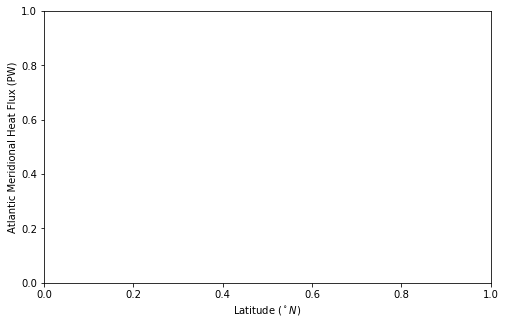

In [10]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Atlantic Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    print(ekey)
    latv, MHF = find_AtlMHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('Atlantic meridional_heat_transport')